In [1]:
import batoid
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Rays
The most fundamental object in batoid is the `Ray`, which you can roughly think of as a photon.  Rays are defined primarily by their position `r` and velocity vector `v`.  Positions in batoid are always specified in meters, and velocities are always in units of the speed of light in vaccuum.  This makes the magnitude of the velocity vector equal to $1/n$, where $n$ is the refractive index of the medium in question.  If you're just planning on geometrically tracing rays through reflective optics, then positions and velocities are the only required Ray parameters (and are the only required elements in the `Ray` constructors).

The next most important `Ray` attribute after position and velocity is `wavelength`, which is (almost always) required for tracing through refractive optics.  (The exception is if you define a refractive medium that doesn't depend on wavelength.  Real media do have wavelength-dependent indices of course.)  Ray wavelengths are always specified in meters, and always in vaccuum -- even when the Ray being created isn't currently in vaccuum.  If you don't specify a value for `wavelength` explicitly when constructing a `Ray`, a (somewhat nonsensical) value of 0.0 meters will be used.

Next in the list of `Ray` attributes is time `t`.  Batoid doesn't track time directly, but rather tracks the product of time and the speed of light in vaccuum.  That product has dimensions of length, so time in batoid is measured in meters.  Note that this convention is complementary to the convention of tracking velocity in units of the speed of light in vaccuum -- we still have the familiar relation $\Delta \vec{r} = \vec{v} \Delta t$.  The default value of time `t` for a `Ray` is 0.0 meters.

The final fundamental attributes of a `Ray` are status indicators for whether a `Ray` has become `vignetted` during tracing, or if batoid `failed` to successfully trace a `Ray` for some reason.  These and a number of additional derived attributes will be discussed more below.

In [2]:
#Create a Ray from position and velocity scalars
x, y, z = 0.1, 0.2, 0.3  # meters
vx, vy, vz = 0.1, 0.2, np.sqrt(1 - 0.1**2 - 0.2**2)  # in units of c

ray = batoid.Ray(x, y, z, vx, vy, vz)

# alternatively, you can pass a 3-element sequence for the position and velocity
r = (x, y, z)
v = (vx, vy, vz)
ray2 = batoid.Ray(r, v)

assert ray == ray2

In [3]:
# Printing the ray reveals its attributes.
print(ray)

Ray([0.1,0.2,0.3],[0.1,0.2,0.974679])


In [4]:
# Regardless of how you create a Ray, you can access its position and velocity attributes
# either as scalars or as vectors.
print(ray.x)
print(ray.vz)

print(ray.r)
print(ray.v)

assert ray.r[0] == ray.x
assert ray.r[1] == ray.y
assert ray.r[2] == ray.z
assert ray.v[0] == ray.vx
assert ray.v[1] == ray.vy
assert ray.v[2] == ray.vz

0.1
0.9746794344808963
[ 0.1  0.2  0.3]
[ 0.1         0.2         0.97467943]


In [5]:
# Rays have a number of optional fields too
print(ray.t)  # The time in meters (see explanation above)
print(ray.wavelength)  # Vaccuum wavelength in meters.
print(ray.vignetted)  # Whether or not the ray has been vignetted
print(ray.failed)  # Whether or not the ray is failed.  
                   # Usually this means an intersection between the Ray and a Surface could not be found.

0.0
0.0
False
False


In [6]:
# You can create rays with specific values for these optional fields too 
# (except for failed, which always starts out as False)
ray = batoid.Ray(r, v, t=0.3, wavelength=400e-9, vignetted=True)
print(ray)

Ray([0.1,0.2,0.3],[0.1,0.2,0.974679], t=0.3, wavelength=4e-07, vignetted=True)


### Derived Ray attributes
Two additional attributes derivable from the fundamental attributes detailed above are the wavevector $\vec{k}$ and the temporal frequency $\omega$.  The wavevector is defined by

$$\vec{k} = \frac{2 \pi \vec{v}}{\lambda |\vec{v}|^2}$$

(with $\lambda$ being the vacuum wavelength) and has units of radians per meter.

The normal physics definition of angular temporal frequency is $\omega = \frac{2 \pi c}{\lambda}$, but in batoid, we divide out the speed of light in vaccuum to get

$$\omega = \frac{2 \pi}{\lambda}$$.

The units are again radians per meter (but this time in a scalar variable).  This choice for the frequency means that $\omega t$ is a phase angle in batoid (just as $\vec{k} \cdot \vec{r}$ is).

In [7]:
print(ray.omega)  # angular frequency
print(ray.k)  # wave vector
print(ray.kx)  # individual components of the wave vector are also accessible directly
assert ray.k[0] == ray.kx
assert ray.k[1] == ray.ky
assert ray.k[2] == ray.kz

15707963.267948966
[  1570796.3267949    3141592.65358979  15310228.75485119]
1570796.326794897


### Ray methods
The first set of methods available to `Ray` is for propagation of the photon through time.  The `positionAtTime` method accepts a time (still in meters) and returns the position of the `Ray` at that past, present, or future time.  The `propagatedToTime` method is similar, but returns a new `Ray` object at the propagated position instead of the position itself.  Finally, the `propagateInPlace` method mutates the `Ray` in place, which is generally a little faster, but destroys the original `Ray`, of course.

For the second set of `Ray` methods, we change our conception of what a ray is: from a propagating infinitesimal point to a propagating plane wave.  I.e., we imagine that the velocity `v` attribute is that of a plane wave, and that the position `r` and time `t` together indicate a point in space-time where the wave amplitude is a maximum.  Note that these conditions will remain true as we propagate the wave in time.

The `phase` method accepts a position and time and returns the phase $\phi$ of this plane wave in radians.  The `amplitude` method returns the complex amplitude $\exp(i \phi)$.

In [8]:
ray = batoid.Ray([0,0,0], [0,0,1])
print(ray)
print(ray.positionAtTime(1.0))  # propagated from (0,0,0) to (0,0,1)
print(ray.propagatedToTime(1.0))  # new ray at (0,0,1) and with t=1
print(ray)  # original ray didn't change though
ray.propagateInPlace(2.0)  # propagate in-place from (0,0,0), t=0 to (0,0,2), t=2
print(ray)

Ray([0,0,0],[0,0,1])
[ 0.  0.  1.]
Ray([0,0,1],[0,0,1], t=1)
Ray([0,0,0],[0,0,1])
Ray([0,0,2],[0,0,1], t=2)


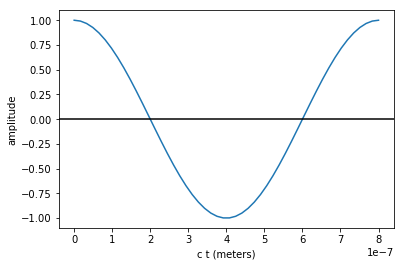

In [9]:
# Plot one period of the plane wave with wavelength 800e-9 m
wavelength = 800e-9
ray = batoid.Ray([0,0,0], [0,0,1], t=0, wavelength=wavelength)
ts = np.linspace(0, wavelength)
plt.plot(ts, [np.cos(ray.phase([0,0,0], t)) for t in ts])
plt.axhline(0, c='k')
plt.xlabel("c t (meters)")
plt.ylabel("amplitude")

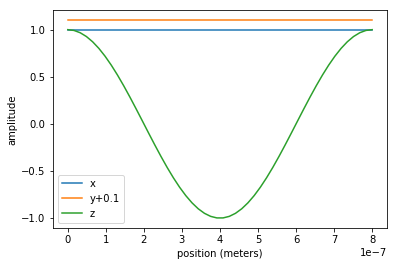

In [10]:
# We can also look at a fixed time over a small region of space
# Since the wave is travelling in the +z direction, its amplitude
# varies with z, but not with x or y
wavelength = 800e-9
ray = batoid.Ray([0,0,0], [0,0,1], t=0, wavelength=wavelength)
xs = ys = zs = np.linspace(0, wavelength)
plt.plot(xs, [np.cos(ray.phase([x,0,0], 0)) for x in xs], label='x')
plt.plot(ys, [np.cos(ray.phase([0,y,0], 0))+0.1 for y in ys], label='y+0.1')
plt.plot(zs, [np.cos(ray.phase([0,0,z], 0)) for z in zs], label='z')
plt.xlabel("position (meters)")
plt.ylabel("amplitude")
plt.legend()

### RayVector
There are many times when you may want to work with more than one ray simultaneously.  While this could be done using, say, a regular python list of `Ray`s, it's more efficient to use a batoid `RayVector`.  The advantage is that this allows more of the looping over `Ray`s to occur in the c++ layer as opposed to the python layer.

`RayVector`s behave similarly to python lists, and can even be constructed from python lists of `Ray`s.

In [11]:
ray1 = batoid.Ray(0,0,0,0,0,1,0,500e-9)
ray2 = batoid.Ray(1,0,0,0,0,1,0,600e-9)
ray3 = batoid.Ray(0,1,0,0,0,1,0,700e-9)
ray4 = batoid.Ray(0,0,1,0,0,1,0,800e-9)


rayVector = batoid.RayVector([ray1, ray2, ray3, ray4])

assert rayVector[0] == ray1
assert rayVector[1] == ray2
assert rayVector[2] == ray3
assert rayVector[3] == ray4

`RayVector`s have the same attributes as `Ray`s, but return numpy arrays with the first dimension corresponding to their different constituent `Ray`s.

In [12]:
print(rayVector.vx)  # x component of each Ray's velocity
print(rayVector.r)  # 2D array containing each Ray's position.
print(rayVector.r.shape)  # First index ranges over the different Rays.
print(rayVector.omega)  # Derived attributes work too.

[ 0.  0.  0.  0.]
[[ 0.  0.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]
(4, 3)
[ 12566370.61435917  10471975.51196598   8975979.01025655
   7853981.63397448]


`RayVector`s have the same methods as `Ray`s.  Note that they still only accept single position and time arguments though, which are then used for all of the constituent `Ray`s.

In [13]:
rayVector = batoid.RayVector([ray1, ray2, ray3, ray4])
print(rayVector.positionAtTime(1))
rayVector2 = rayVector.propagatedToTime(1)
assert rayVector != rayVector2
rayVector.propagateInPlace(1)
assert rayVector == rayVector2

[[ 0.  0.  1.]
 [ 1.  0.  1.]
 [ 0.  1.  1.]
 [ 0.  0.  2.]]


In [14]:
print(rayVector.phase([0,0,0], 0))
print(rayVector.amplitude([0,0,0], 1))

[0.0, 0.0, 0.0, -7853981.633974483]
[(1-9.698802766866083e-10j), (-0.5000000003754479+0.8660254035676737j), (-0.9009688683184546-0.4338837382536517j), (1-2.8102777124278216e-10j)]


`RayVector`s also have a few additional methods not present for `Ray`.  

The `sumAmplitude` method is similar to the `amplitude` method, but adds the complex amplitudes of each `Ray`'s plane wave together.  This could be done in python, of course, but is significantly faster in some cases to do on the c++ side.

The `trimVignetted` and `trimVignettedInPlace` methods work to remove `Ray`s that have `.vignetted==True`.  We'll examine these methods in a future tutorial.

In [15]:
assert sum(rayVector.amplitude([0,0,0],0)) == rayVector.sumAmplitude([0,0,0], 0)

### rayGrid and circularGrid
It can be slow to construct large grids of `Ray`s in python just to then assemble them into `RayVector`s.  To help speed up this construction, batoid includes two convenience functions that can be used to rapidly create commonly desired grids of rays.  These are `batoid.rayGrid` and `batoid.circularGrid`.  In both cases, the goal is to uniformly sample a plane wave incident upon some optical system by creating a grid of parallel and cophased `Ray`s.  For `rayGrid`, these assembled `Ray`s occupy a square region of space, and for `circularGrid`, they occupy a circular or annular region.  `RayVector`s assembled this way are the foundation for many of the analyses computable by batoid.

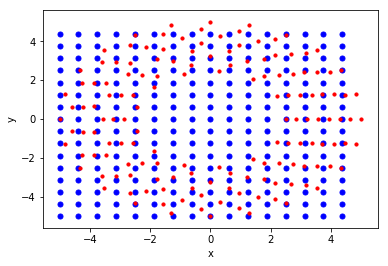

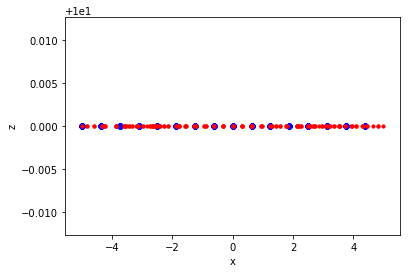

In [16]:
zdist = 10  # mean distance above the origin of the rayVector
length = 10  # size of the square region
xcos, ycos, zcos = 0, 0, -1  # direction cosine for the rays velocities.
nside = 16  # number of rays on a side of the square grid
wavelength = 500e-9
medium = batoid.ConstMedium(1.0)  # medium in which rays originate.  
                                  # We'll examine Mediums more in a future tutorial.

rays = batoid.rayGrid(
    zdist, length, xcos, ycos, zcos, nside, wavelength, medium
)

# Similar but not quite identical arguments for circularGrid.
outer = 5.0  # outer radius of annulus in meters
inner = 2.5  # inner radius of annulus in meters
nradii = 8  # number of radii (rings)
naz = 24  # number of point around outermost ring
circularRays = batoid.circularGrid(
    zdist, outer, inner, xcos, ycos, zcos, nradii, naz, wavelength, medium
)

# In the plot, you can see that the rays span the range from -5 to +5 meters
plt.scatter(rays.x, rays.y, c='b', s=25)
plt.scatter(circularRays.x, circularRays.y, c='r', s=10)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

plt.scatter(rays.x, rays.z, c='b', s=25)
plt.scatter(circularRays.x, circularRays.z, c='r', s=10)
plt.xlabel("x")
plt.ylabel("z")
plt.show()

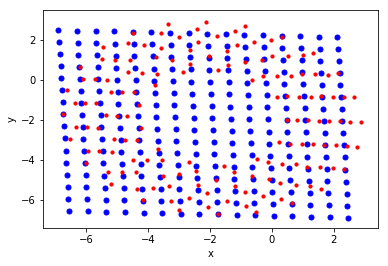

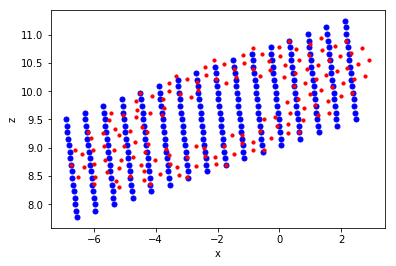

In [17]:
# If we want to tilt the incoming plane wave, then we manipulate the direction cosines.  
# The batoid.gnomicToDirCos function can help with this
theta_x = 0.2 # radians
theta_y = 0.2
xcos, ycos, zcos = batoid.utils.gnomicToDirCos(theta_x, theta_y)
zcos *= -1  # have rays point down, not up

rays = batoid.rayGrid(
    zdist, length, xcos, ycos, zcos, nside, wavelength, medium
)
circularRays = batoid.circularGrid(
    zdist, outer, inner, xcos, ycos, zcos, nradii, naz, wavelength, medium
)

plt.scatter(rays.x, rays.y, c='b', s=25)
plt.scatter(circularRays.x, circularRays.y, c='r', s=10)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

plt.scatter(rays.x, rays.z, c='b', s=25)
plt.scatter(circularRays.x, circularRays.z, c='r', s=10)
plt.xlabel("x")
plt.ylabel("z")
plt.show()